## Image Analysis

In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data_dir = "../data/oct24_clean/"

games = pd.read_csv(data_dir + "games.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")

In [3]:
df = games.loc[:, ["app_id", "name"]]
df = df.merge(spy.loc[:, ["app_id", "concurrent_users_yesterday"]], how="inner", on="app_id")
df = df.merge(genres, how="right", on="app_id")

top_n = 100
top = df.sort_values(by="concurrent_users_yesterday", ascending=False).groupby("genre").head(top_n)
counts = top.genre.value_counts()
top = top[top["genre"].map(counts) >= top_n]

df = pd.DataFrame({"app_id": top.app_id.unique()})
df

,app_id
0,730
1,578080
2,570
3,1203220
4,1172470
...,...
1407,2156010
1408,2315530
1409,2342230
1410,2412080


## Load Images

In [4]:
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

image_dir = "../data/img/header"

images = dict()

for app_id in df.app_id:
    images[app_id] = load_image(f"{image_dir}/{app_id}.jpg")

In [5]:
def show_images(imgs):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

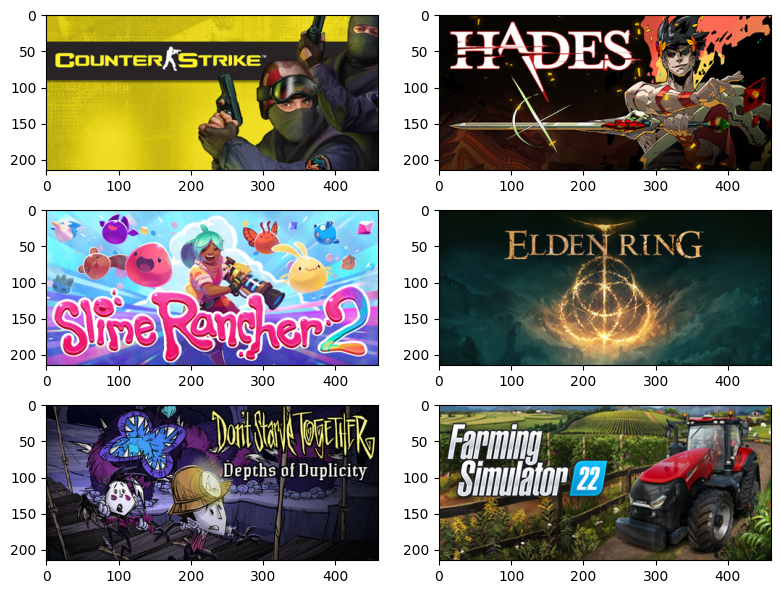

In [43]:
# example_ids = [10, 1366540, 322330, 238460,]
example_ids = [10, 1145360, 1657630, 1245620, 322330, 1248130]

# example_ids = np.random.choice(df.app_id, size=(6,))
show_images([images[id] for id in example_ids])

## K-Means Quantization

In [9]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

def find_top_colors(image_array, k):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(image_array)
    return kmeans.cluster_centers_  # Get dominant colors

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using KNN."""
    knn = NearestNeighbors(n_neighbors=1)  # Find the closest color
    knn.fit(top_colors)  # Train on the dominant colors
    _, indices = knn.kneighbors(image_array)  # Find closest colors
    
    # Map each pixel to its nearest top color
    replaced_image_array = top_colors[indices.flatten()]
    return replaced_image_array

def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    image_array = image_array.reshape((1, -1, 3))  # Add extra dimension for OpenCV
    lab_image = cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB)
    return lab_image

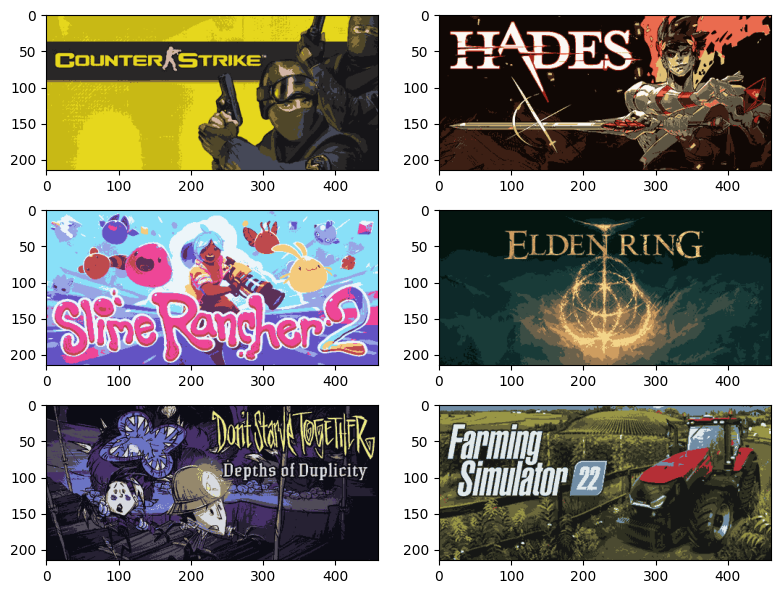

In [12]:
k = 8
knn_images = []

for img_idx in example_ids:
    flat_lab = rgb_to_lab(images[img_idx]).reshape(-1, 3)

    top_colors = find_top_colors(flat_lab, k)

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(images[img_idx].shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB) # Back to RGB

    knn_images.append(knn_image)

show_images(knn_images)

## Structural Analysis with PCA

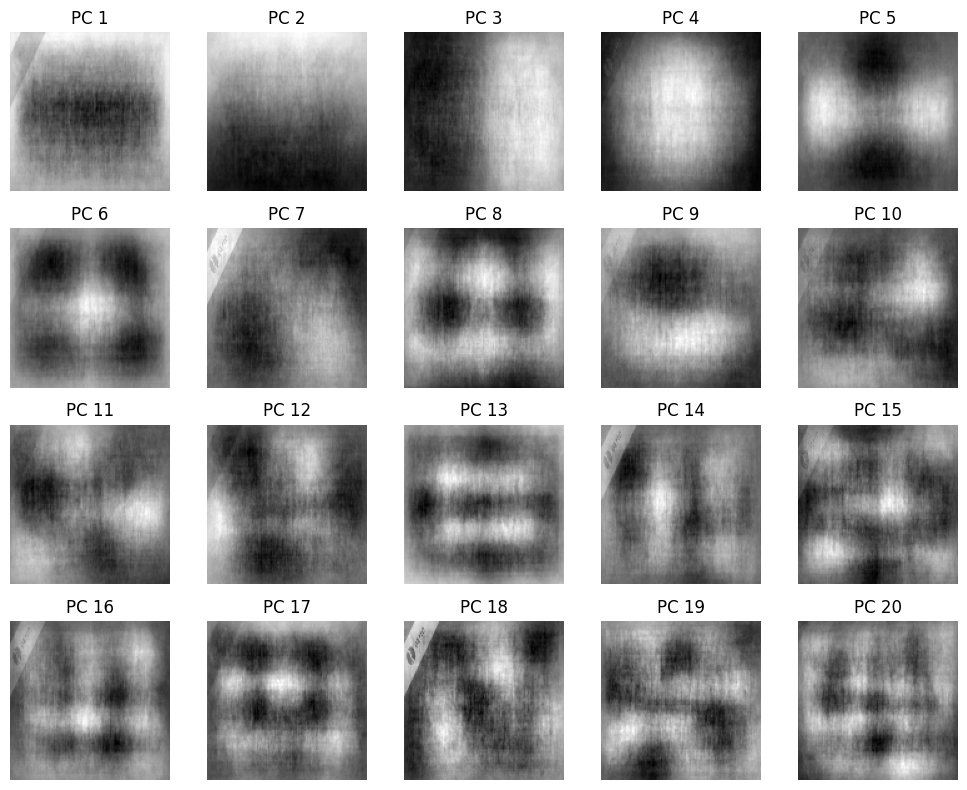

In [60]:
from sklearn.decomposition import PCA

EIG_SIZE = (128, 128)
EIG_COMPONENTS = 20

# Convert images to grayscale and flatten
eig = []
eig_keys = []

for key, img in images.items():
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized = cv2.resize(gray, EIG_SIZE)          # Resize to fixed size
    flattened = resized.flatten()                 # Flatten into 1D vector
    eig.append(flattened)
    eig_keys.append(key)

# Stack all images into a matrix (each row is an image)
image_matrix = np.stack(eig)

# Apply PCA
pca = PCA(n_components=EIG_COMPONENTS)
pca.fit(image_matrix)

# Visualize the top principal components (Eigenimages)
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i >= EIG_COMPONENTS:
        break
    eigenimage = pca.components_[i].reshape(EIG_SIZE)  # Reshape back to image
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Project images onto principal components
pca_features = pca.transform(image_matrix)